In [1]:
from edc import check_compatibility
check_compatibility("user-2023.03-02", dependencies=["XCUBE_GEN"])



---------

The following environment variables are available:

* `XCUBE_GEN_AUTH_AUD`, `XCUBE_GEN_API_SERVER_PORT`, `XCUBE_GEN_AUTH_DOMAIN`, `XCUBE_GEN_AUTH_CLIENT_ID`, `XCUBE_GEN_AUTH_CLIENT_SECRET`, `XCUBE_GEN_API_SERVER_URL`


# Introduction on how to use xcube generator service
## Brought to you by Brockmann Consult

This notebook demonstrates how to generate data cubes in zarr format using different data stores offered within EDC. To run the notebook yourself, please make sure you have a xcube generator subscription (https://eurodatacube.com/marketplace/services/edc_xcube_generator). There is a free trial availabe, to get you started right away :) 

In this notebook you will learn how to

-  setup your environment in order to be able to use the xcube generation service,
-  request Sentinel Data,
-  request data from selected Copernicus Service,
-  request data from Copernicus Climate Data Store,
-  request data from ESA Climate Change Initiative.



## 1. Load packages and environment variables, create service configuration

In [2]:
from xcube.core.gen2 import InputConfig
from xcube.core.gen2 import CubeConfig
from xcube.core.gen2 import OutputConfig
from xcube.core.gen2 import CubeGeneratorRequest
from xcube.core.gen2 import CubeGenerator
from xcube.core.gen2 import ServiceConfig
from xcube.core.gen2 import CubeGeneratorError
from xcube.core.store import new_data_store


# utilities
import os
import xcube
import IPython.display
import shapely.geometry
%matplotlib inline

Checking the xcube version:

In [3]:
from xcube.version import version
version

'1.0.1'

The manual creation of the service_config_json will not be required in future versions.

In [4]:
service_config_json = {
  "endpoint_url": os.getenv("XCUBE_GEN_API_SERVER_URL") + "/api/v2", 
  "client_id": os.getenv("XCUBE_GEN_AUTH_CLIENT_ID"), 
  "client_secret": os.getenv("XCUBE_GEN_AUTH_CLIENT_SECRET") 
}

In [5]:
service_config = ServiceConfig.from_dict(service_config_json)

## 2. Requesting Sentinel Data

Before we start, the area of interest needs to be defined. Let's take a look at northern Germany:

In [6]:
x1 = 7.  # degree
y1 = 53  # degree
x2 = 11  # degree
y2 = 55  # degree

bbox = x1, y1, x2, y2

Let's check the region, to make sure it covers the expected area:

In [7]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Please check the table for available Sentinel Data and if you would like to get more information about a particular sensor or band head over to the documentation of the data sets: https://docs.sentinel-hub.com/api/latest/data/

 | Dataset     | Variables               | Data ID |Store ID     | 
| -------- | -------- |----|----|
| `Sentinel-1 GRD`       | `VV`, `VH`, `HV`, `HH` | `S1GRD`| `@sentinelhub_eu` |
| `Sentinel-2 MSI L1C`   | `B01`, `B02`, `B03`, `B04`, `B05`, `B06`, `B07`, `B08`, `B8A`, `B09`, `B10`, `B11`, `B12` | `S2L1C`| `@sentinelhub_eu` |
| `Sentinel-2 MSI L2A`   | `B01`, `B02`, `B03`, `B04`, `B05`, `B06`, `B07`, `B08`, `B8A`, `B09`, `B10`, `B11`, `B12` | `S2L2A`| `@sentinelhub_eu` |
| `Sentinel-3 OCLI L1B`  | `B01`, `B02`, `B03`, `B04`, `B05`, `B06`, `B07`, `B08`, `B09`, `B10`, `B11`, `B12`, `B13`, `B14`, `B15`, `B16`, `B17`, `B18`, `B19`, `B20`, `B21` | `S3OLCI`| `@sentinelhub_creodias` |


In the following example we will request a cube for  `Sentinel-2 MSI L2A` with the `"data_id": "S2L2A"`.    
  
Now let's create a request for the xcube generator. JSON is used here, because it could be loaded in this form from a file as well.   

A request consists of three parts: **input_config**, **cube_config** and **output_config**. 

**input_config**: Defines the source of input data as well as the particular dataset identifier `data_id`.   
**cube_config**: This is where the cube is configured. Include all information like desired variables, bounding box `bbox` or time range.   
**output_config**: Details of the target destination of the cube. The example configuration includes a public-read bucket which holds data for **4 days only**Requesting. If you use this configuration and you want to keep your data, please make sure to give a unique data_id for your cube name, because anybody can set the parameter "replace" to true and (accidentally) overwrite your cube within the eurodatacube-scratch bucket if it happens to have the exact same data_id! If you wish to save the data into your own bucket please use the following output_config:

    "output_config": {
    "store_id": "s3",
    "data_id": "name_your_cube.zarr",
    "replace": True,
    "store_params": {
      "bucket_name": "name_of_your_aws_s3_bucket", 
      "aws_access_key_id": "AWS_ACCESS_KEY",
      "aws_secret_access_key": "AWS_SECRET"
    }


In [8]:
input_config = InputConfig(
    store_id="@sentinelhub_eu",
    data_id="S2L2A",
)

cube_config = CubeConfig(
   variable_names=["B04", "B05"],
   tile_size=[512, 512],
   spatial_res=0.001,           
   bbox = bbox,      
   time_range=["2021-03-01", "2021-03-06"]
)

output_config = OutputConfig(
    store_id="@eurodatacube_scratch",
    replace=True,
    data_id="SH_demo.zarr"
)

In [9]:
request = CubeGeneratorRequest(
    input_config=input_config,
    cube_config=cube_config,
    output_config=output_config
)

To inspect the costs of the configured cube you can do it with the following lines. In the cube_info you will see, that the requested cube has an estimated cost of 384 processing units and the limit is set to 10000. The available processing units will depend on your subscription plan and whether you have already generated cubes or not. 

In [10]:
generator_service = CubeGenerator.new(service_config=service_config, verbosity=1)

In [11]:
generator_service.get_cube_info(request)

<xcube.core.gen2.response.make_cube_generator_result_class.<locals>.SpecificCubeGeneratorResult at 0x7f10f6d87460>

Let's go ahead, and generate the cube. Note that depending on the cube's size this may take up to several minutes. Once it is generated the `data_id` you assinged in the `output_config` of your request will be returned. In case the cube request is missing a `data_id` a generated name will be returned.

In [12]:
result = generator_service.generate_cube(request)

In [13]:
result

<xcube.core.gen2.response.make_cube_generator_result_class.<locals>.SpecificCubeGeneratorResult at 0x7f10f6d517c0>

To see, which cubes ar avaialable in a certain bucket, you can configure a store to show them. Here we use the eurodatacube-scratch bucket - so you will see all the cubes that have been placed in this bucket. **Keep in mind**: The content of eurodatacube-scratch is only available for **4 days** starting at the creation-moment! If you want to see the content of your own bucket, change the bucket name and in case it is not public-read you need to pass the credentials `client_kwargs = {"aws_access_key_id":"ACCESS_ID", "aws_secret_access_key":"SECRET_KEY"}`. In case you use your own private bucket you need to configure the new_data_store like this: `xcube_store = new_data_store("s3", bucket_name="eurodatacube-scratch", **client_kwargs)`

In [14]:
xcube_store = new_data_store("s3", root="eurodatacube-scratch", storage_options=dict(anon=True))

In [15]:
dataset_id_list = list(xcube_store.get_data_ids())

In [16]:
dataset_id_list

['COP_demo_v2.zarr',
 'SH_demo.zarr',
 'cci-chlor_a.zarr',
 'volumetric_surface_soil_moisture.zarr']

Let's checkout the cube we just created:

In [17]:
ds = xcube_store.open_data("SH_demo.zarr")
ds

<xarray.Dataset>
Dimensions:    (time: 4, lat: 2048, lon: 4096, bnds: 2)
Coordinates:
  * lat        (lat) float64 55.05 55.05 55.05 55.04 ... 53.0 53.0 53.0 53.0
  * lon        (lon) float64 7.0 7.002 7.002 7.003 ... 11.09 11.09 11.09 11.1
  * time       (time) datetime64[ns] 2021-03-01T10:55:53 ... 2021-03-05T10:35:56
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(4, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes: (12/18)
    Conventions:                CF-1.7
    date_created:               2023-03-22T13:42:07.427475
    geospatial_bounds:          POLYGON((7 53, 7 55.048, 11.096 55.048, 11.09...
    geospatial_bounds_crs:      CRS84
    geospatial_lat_max:         55.048
    geospatial_lat_min:         53
    ...                         ...
    history:                    [{'cube_config': {'band_fill_values': None, '...
    processing_level:           L2A
    time_coverage_duration:     P3DT23H40M56S
    time_coverage_end:          2021-03-05T10:36:25+00:00
    time_coverage_start:        2021-03-01T10:55:29+00:00
    title:                      S2L2A Data Cube Subset

Now, let's take a look at the plot of the data:

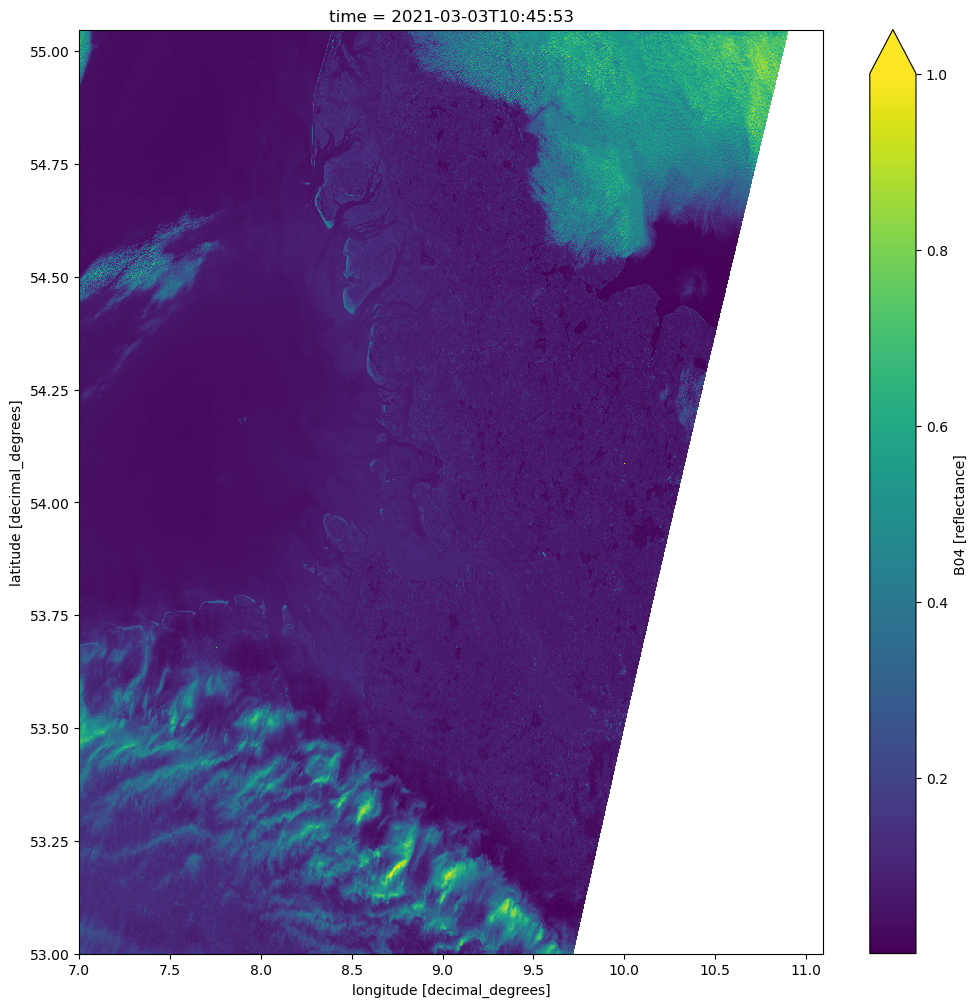

In [18]:
ds.B04.isel(time=2).plot(figsize=[12,12], vmax=1.0)

## 3. Requesting selected Copernicus Service. 
Available data IDs with their associated variable names are the following: 
    
| Store_id | Dataset                                              | Variables                                                                                                                                                                                                                                                                                                                                                     | Spatial Extent (lon_min, lat_min, lon_max, lat_max) | Spatial Resolution | Temporal Extent|
| ---------------------------------------------------- | ---------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |------------------------------------------------------|-------------------|-----------------|
| @cop_services_clms | `LWQ-NRT-300m`                                       | `crs`, `first_obs`, `last_obs`, `num_obs`, `Rw1020_rep`, `Rw400_rep`, `Rw412_rep`, `Rw443_rep`, `Rw490_rep`, `Rw510_rep`, `Rw560_rep`, `Rw620_rep`, `Rw665_rep`, `Rw674_rep`, `Rw681_rep`, `Rw709_rep`, `Rw754_rep`, `Rw760_rep`, `Rw764_rep`, `Rw767_rep`, `Rw779_rep`, `Rw865_rep`, `Rw885_rep`, `Rw900_rep`, `Rw940_rep`, `RwDayNum_rep`, `turbidity_mean` | [-179.99888393, -89.99888393, 179.99888393, 89.99888393] | 300 m (~ 0.002232 deg) | [2018-01-01, 2020-12-21] |
| @cop_services_cmems | `ATL/CHL/OCEANCOLOUR_ATL_CHL_L4_NRT_OBSERVATIONS_009_037`    | `CHL`, `CHL_error`                                                                                                                                                                                                                                                                                                                                            | [-45.994793, 20.005207, 12.994794, 65.99479] | ~ 0.01041 deg| [2019-05-01, 2021-03-14]|
| @cop_services_cmems | `BAL/CHL/OCEANCOLOUR_BAL_CHL_L3_NRT_OBSERVATIONS_009_049`    | `CHL`, `QI`                                                                                                                                                                                                                                                                                                                                                   | [9.258861, 53.255493, 30.241138, 65.844505]| ~ 0.01772 deg | [2018-08-01, 2021-04-01]
| @cop_services_cmems | `BLA/CHL/OCEANCOLOUR_BS_CHL_L4_NRT_OBSERVATIONS_009_045`     | `CHL`                                                                                                                                                                                                                                                                                                                                                         | [26.507038, 40.005062, 41.99296, 47.994938]| ~ 0.01408 deg | [2019-01-01, 2021-03-15]
| @cop_services_cmems | `MED/CHL/OCEANCOLOUR_MED_CHL_L4_NRT_OBSERVATIONS_009_041`    | `CHL`                                                                                                                                                                                                                                                                                                                                                         | [-5.993576, 30.005064, 36.493576, 45.994938]| ~ 0.01284 deg | [2019-01-01, 2021-03-15]
| @cop_services_cmems | `MED/CHL/OCEANCOLOUR_MED_OPTICS_L3_NRT_OBSERVATIONS_009_038` | `KD490`                                                                                                                                                                                                                                                                                                                                                       | [-5.993576, 30.005064, 36.493576, 45.994938]| ~ 0.01284 deg | [2019-01-01, 2021-03-20]

For explanation of the particular steps, please take a look at the description of section **2. Requesting Sentinel Data**, the following cells will not be explained again :) 

In [19]:
input_config = InputConfig(
    store_id="@cop_services_cmems",
    data_id="MED/CHL/OCEANCOLOUR_MED_CHL_L4_NRT_OBSERVATIONS_009_041.zarr",
)

cube_config = CubeConfig(
   variable_names=["CHL"],
   tile_size=[512, 512],
   spatial_res=0.01284,           
   bbox = [0., 35., 10., 45.],      
   time_range=["2019-06-01", "2019-12-31"], 
   time_period="1D"
)

output_config = OutputConfig(
    store_id="@eurodatacube_scratch",
    replace=True,
    data_id="COP_demo_v2.zarr"
)

In [20]:
request = CubeGeneratorRequest(
    input_config=input_config,
    cube_config=cube_config,
    output_config=output_config
)

In [21]:
generator_service = CubeGenerator.new(service_config=service_config, verbosity=1)

In [22]:
generator_service.get_cube_info(request)

<xcube.core.gen2.response.make_cube_generator_result_class.<locals>.SpecificCubeGeneratorResult at 0x7f10e6124160>

In [23]:
result = generator_service.generate_cube(request)

In [24]:
result

<xcube.core.gen2.response.make_cube_generator_result_class.<locals>.SpecificCubeGeneratorResult at 0x7f10e6097d60>

In [25]:
result.result.data_id

'COP_demo_v2.zarr'

In [26]:
xcube_store = new_data_store("s3", root="eurodatacube-scratch", storage_options=dict(anon=True))

In [27]:
dataset_id_list = list(xcube_store.get_data_ids())
dataset_id_list

['COP_demo_v2.zarr',
 'SH_demo.zarr',
 'cci-chlor_a.zarr',
 'volumetric_surface_soil_moisture.zarr']

In [28]:
ds = xcube_store.open_data("COP_demo_v2.zarr")

In [29]:
ds

<xarray.Dataset>
Dimensions:  (time: 206, lat: 779, lon: 779)
Coordinates:
  * lat      (lat) float64 35.01 35.02 35.03 35.04 ... 44.96 44.97 44.98 45.0
  * lon      (lon) float64 0.00642 0.01926 0.0321 0.04494 ... 9.97 9.983 9.996
  * time     (time) datetime64[ns] 2019-06-01 2019-06-02 ... 2020-01-01
Data variables:
    CHL      (time, lat, lon) float64 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                CF-1.7
    citation:                    
    cmems_product_id:           OCEANCOLOUR_MED_CHL_L4_NRT_OBSERVATIONS_009_041
    cmems_production_unit:      OC-CNR-ROMA-IT
    comment:                    r=log10(max([rrs443,rrs490,rrs510])/rrs555) ;...
    contact:                    technical@gos.artov.isac.cnr.it
    ...                         ...
    start_date:                 2021-03-15
    start_time:                 08:00:00 UTC
    stop_date:                  2021-03-15
    stop_time:                  14:00:00 UTC
    title:                      dataset-oc-med-chl-multi-l4-interp_1km_daily-...
    westernmost_longitude:      -6.0

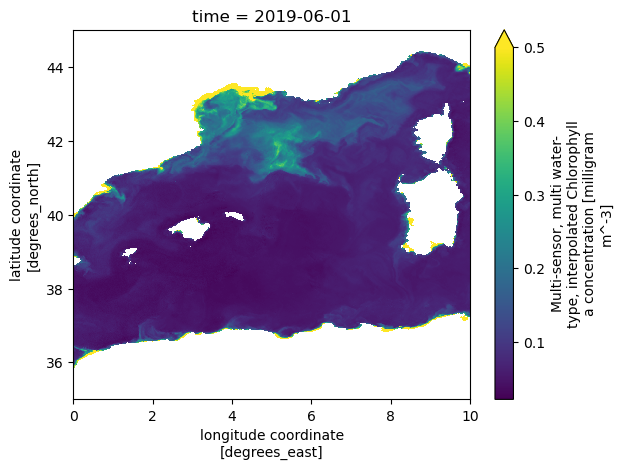

In [30]:
ds.CHL.isel(time=0).plot(vmax=.5)

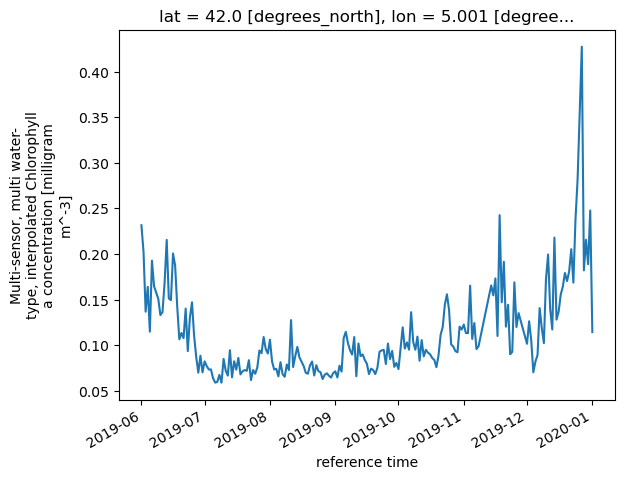

In [31]:
ds.CHL.sel(lat=42.,lon=5., method='nearest').plot()

## 4. Generating data cubes from the Copernicus Climate Data Store
Note that the Climate Data Store (CDS) store uses the CDS API. Due to the sheer amount of data offered by CDS, not all configurations may work with xcube generator service, also due to the limitis of the CDS API itself. Please, contact EDC directly in case you have a specific request for CDS data. More information on Climate Data Store may be found here: 
https://confluence.ecmwf.int/display/CKB/Climate+Data+Store+%28CDS%29+documentation 

For explanation of the particular steps, please take a look at the description of section **2. Requesting data sets from SentinelHub**, the following cells will not be explained again :) 

In [32]:
input_config = InputConfig(
    store_id="@cds",
    data_id="satellite-soil-moisture:volumetric:monthly",
)

cube_config = CubeConfig(
   variable_names=["volumetric_surface_soil_moisture"],
   tile_size=[512, 512],
   spatial_res=0.25,           
   time_range=["2015-01-01", "2015-12-31"]
)

output_config = OutputConfig(
    store_id="@eurodatacube_scratch",
    replace=True,
    data_id="volumetric_surface_soil_moisture.zarr"
)

In [33]:
request = CubeGeneratorRequest(
    input_config=input_config,
    cube_config=cube_config,
    output_config=output_config
)

In [34]:
generator_service.get_cube_info(request)

<xcube.core.gen2.response.make_cube_generator_result_class.<locals>.SpecificCubeGeneratorResult at 0x7f10e5cf52e0>

In [35]:
generator_service = CubeGenerator.new(service_config=service_config, verbosity=1)

In [36]:
result = generator_service.generate_cube(request)

In [37]:
result

<xcube.core.gen2.response.make_cube_generator_result_class.<locals>.SpecificCubeGeneratorResult at 0x7f10e5ce7eb0>

In [38]:
xcube_store = new_data_store("s3", root="eurodatacube-scratch", storage_options=dict(anon=True))

In [39]:
dataset_id_list = list(xcube_store.get_data_ids())

In [40]:
dataset_id_list

['COP_demo_v2.zarr',
 'SH_demo.zarr',
 'cci-chlor_a.zarr',
 'volumetric_surface_soil_moisture.zarr']

In [41]:
ds = xcube_store.open_data("volumetric_surface_soil_moisture.zarr")

In [42]:
ds

<xarray.Dataset>
Dimensions:     (time: 12, lat: 720, lon: 1440)
Coordinates:
  * lat         (lat) float32 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon         (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time        (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2015-12-01
Data variables:
    freqbandID  (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    nobs        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    sensor      (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    sm          (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                CF-1.7
    cdm_data_type:              Grid
    comment:                    These data were produced as part of the Coper...
    contact:                    C3S_SM_Science@eodc.eu
    creator_email:              C3S_SM_Science@eodc.eu
    creator_name:               Earth Observation Data Center (EODC)
    ...                         ...
    time_coverage_duration:     P1M
    time_coverage_end:          2015-12-31T12:00:00Z
    time_coverage_resolution:   P1D
    time_coverage_start:        2014-12-31T12:00:00Z
    title:                      C3S Surface Soil Moisture merged COMBINED Pro...
    tracking_id:                4d788889-b8c0-43b3-a622-f61b22adfc51

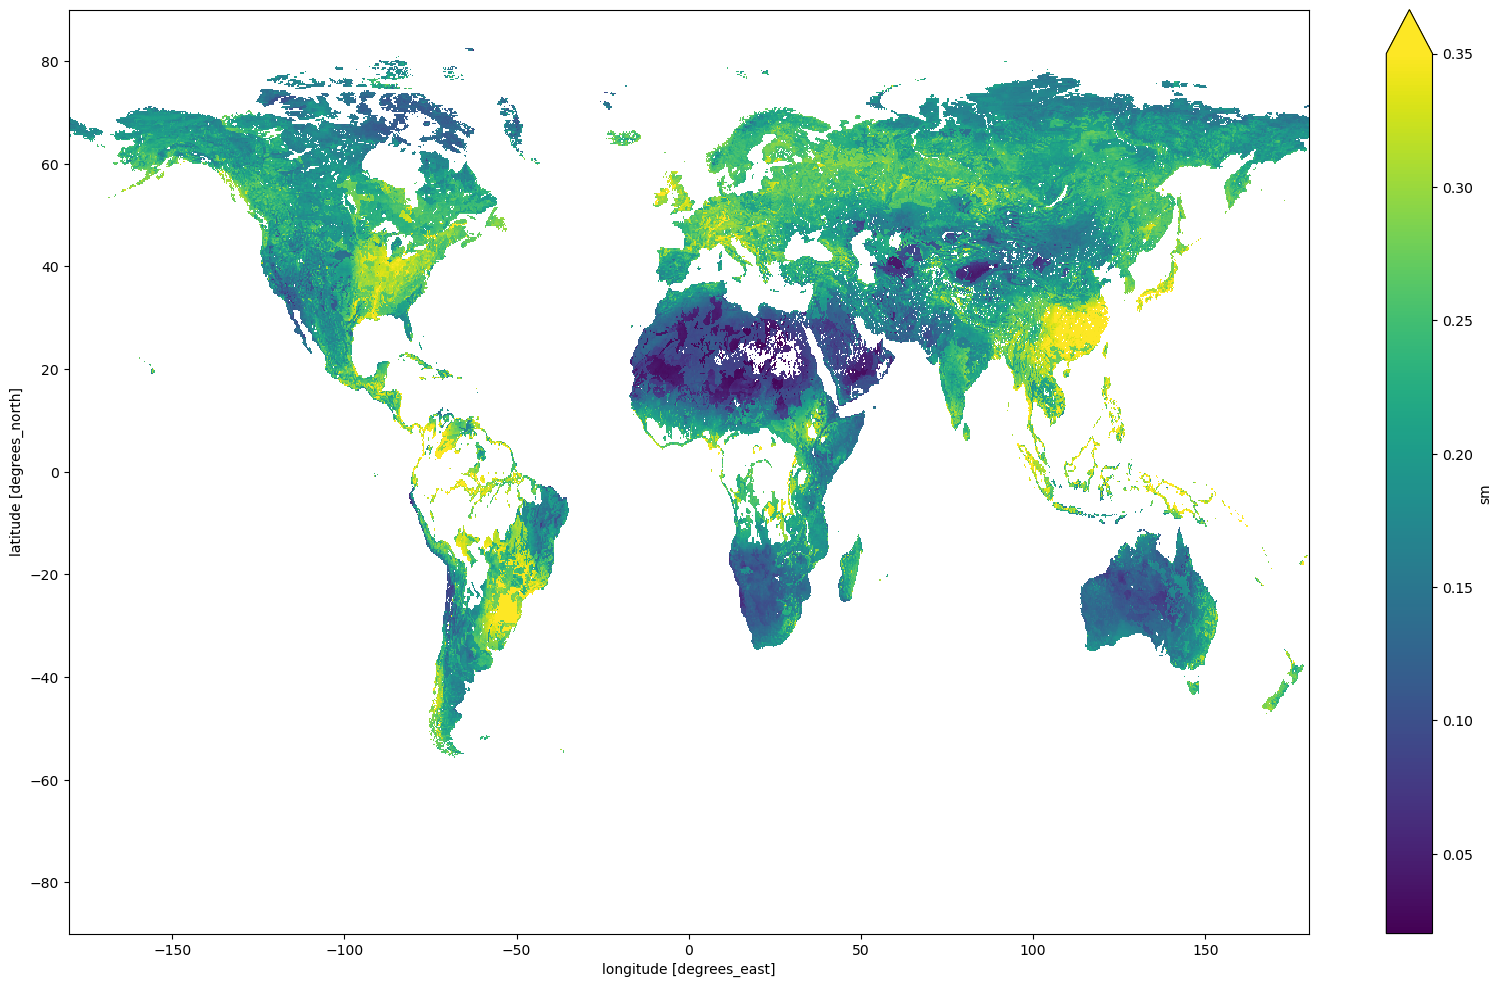

In [43]:
ds.sm.mean(dim='time').plot(figsize=[20,12], vmax=0.35)

## 5. Generating data cubes from ESA Climate Change Initiative data
Note that the CCIODP store uses the Open Data Portal (ODP) API. Due to the sheer amount of data offered by ODP, not all configurations may work with xcube generator service, also due to the limitis of the ODP API itself. Please, contact EDC directly in case you have a specific request for ODP data. More information on Open Data Portal may be found here: 
https://climate.esa.int/en/explore/access-climate-data/

For explanation of the particular steps, please take a look at the description of section **2. Requesting data sets from SentinelHub**, the following cells will not be explained again :) 

In [44]:
input_config = InputConfig(
    store_id="@cciodp",
    data_id="esacci.OC.mon.L3S.CHLOR_A.multi-sensor.multi-platform.MERGED.3-1.geographic",
)

cube_config = CubeConfig(
   variable_names=["chlor_a"],
   spatial_res=0.041666666666666664,           
   bbox = [-180, -90, 180, 90],      
   time_range=["2008-01-01", "2008-07-01"],
   time_period = "1M",
   chunks= {"time": 1,
             "lat": 1024,
            "lon": 1024
           }
)

output_config = OutputConfig(
    store_id="@eurodatacube_scratch",
    replace=True,
    data_id="cci-chlor_a.zarr"
)

In [45]:
request = CubeGeneratorRequest(
    input_config=input_config,
    cube_config=cube_config,
    output_config=output_config
)

In [46]:
generator_service = CubeGenerator.new(service_config=service_config, verbosity=1)

In [47]:
generator_service.get_cube_info(request)

<xcube.core.gen2.response.make_cube_generator_result_class.<locals>.SpecificCubeGeneratorResult at 0x7f10e5baed30>

In [48]:
result = generator_service.generate_cube(request)

In [49]:
result.result.data_id

'cci-chlor_a.zarr'

In [50]:
xcube_store = new_data_store("s3", root="eurodatacube-scratch", storage_options=dict(anon=True))

In [51]:
dataset_id_list = list(xcube_store.get_data_ids())
dataset_id_list

['COP_demo_v2.zarr',
 'SH_demo.zarr',
 'cci-chlor_a.zarr',
 'volumetric_surface_soil_moisture.zarr']

In [52]:
ds = xcube_store.open_data("cci-chlor_a.zarr")

In [53]:
ds

<xarray.Dataset>
Dimensions:    (time: 7, lat: 4320, lon: 8640, bnds: 2)
Coordinates:
  * lat        (lat) float32 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon        (lon) float32 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2008-01-16T12:00:00 ... 2008-07-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(7, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    chlor_a    (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes: (12/18)
    Conventions:                CF-1.7
    date_created:               2023-03-22T13:47:39.367975
    geospatial_bounds:          POLYGON((-180 -90, -180 90, 180 90, 180 -90, ...
    geospatial_bounds_crs:      CRS84
    geospatial_lat_max:         90
    geospatial_lat_min:         -90
    ...                         ...
    history:                    [{'cube_params': {'bbox': [-180.0, -90.0, 180...
    processing_level:           L3S
    time_coverage_duration:     P213DT0H0M0S
    time_coverage_end:          2008-08-01T00:00:00
    time_coverage_start:        2008-01-01T00:00:00
    title:                      esacci.OC.mon.L3S.CHLOR_A.multi-sensor.multi-...

Uncomment the below cell to view the plot, this takes a moment :)

In [54]:
#ds.chlor_a.isel(time=1).plot(vmax = 1., figsize=[24,12])